In [1]:
import os, requests, base64, random, json

from io import BytesIO
from PIL import Image

import gradio as gr

# gradio versionshould be > 3.3
assert gr.__version__ > '3.3'


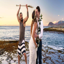

In [2]:
# some sample images
img_url1 = "https://drive.google.com/uc?export=download&id=1wCOSJDajr7As6mEvAH5Ze1W9qDQCABpd"
img_url2 = "https://drive.google.com/uc?export=download&id=1tFyeX0M7-yKpk_79bkNYSZd9KE0IJUUN"
img_url3 = "https://drive.google.com/uc?export=download&id=1cJl8PEOqKsYqAlDQovSjdlbbR_nClGTu"
img_url4 = "https://drive.google.com/uc?export=download&id=1OvMNZGQ2lOC-6XtvimS0iwbBihOkFx6T"

#for getting sample images
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

if not os.path.exists('image'):
    os.makedirs('image')
    download_image(img_url1).resize((512, 512)).save('image/dog.jpg')
    download_image(img_url2).resize((512, 512)).save('image/photobomb1.jpg')
    download_image(img_url3).resize((512, 512)).save('image/photobomb2.jpg')
    download_image(img_url4).resize((512, 512)).save('image/photobomb3.jpg')
    
Image.open('image/photobomb3.jpg').resize((64,64))    

In [3]:
magic_url = 'http://localhost:6000/magic'

def image2str(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return str(base64.b64encode(buffered.getvalue()).decode("utf-8"))

def str2image(encstr):
    return Image.open(BytesIO(base64.b64decode(encstr)))

# test the image encoding function
if False:
    #output = image2str(Image.open('image/photobomb3.jpg').resize((512, 512)))
    #print(output[:50])

    #str2image(output)
    pass


def get_stable_diffusion_images(init_image, mask_prompt, target_prompt):
    #prompt = "a cat sitting on bench"
    strength= .75
    guidance_scale=8.5
    num_samples = 4
    n_iter = 1
    
    response = requests.post(magic_url, json = {
        'init_image': image2str(init_image),
        'mask_prompt': mask_prompt,
        'target_prompt': target_prompt
    })
    #print(response)
    
    if (response.status_code == 200):
        parse_json = json.loads(response.text)
        #print('Response success. Process time:', parse_json['execution_time'], 's')
        
        # decode the images
        magic_images = []
        for image_str in parse_json['result']:
            magic_images.append(str2image(image_str))

        return magic_images
        
    else:
        print('Error')
        return None

%time get_stable_diffusion_images(Image.open('image/dog.jpg'), 'Dog', 'Cat sitting on bench')    

CPU times: user 21.7 ms, sys: 3.27 ms, total: 25 ms
Wall time: 7.03 s


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F775750B9D0>]

In [4]:
demo = gr.Blocks()

examples = [['image/dog.jpg', 'Dog', 'Cat sitting on bench'], 
            ['image/photobomb2.jpg', 'bride', 'a giraffe'],
            ['image/photobomb1.jpg', 'girl in blue dress', 'a man in blue shirt'],
            ['image/photobomb3.jpg', 'man in shorts', 'a tree']]

with demo:
    gr.Markdown("<h1><center>Diffusing InPainting and Visual Grounding together</center></h1>")
    gr.Markdown("""<h3><center>Stable Diffusion - InPainting - OFA (ICML2022) Pipeline</center></h3>""")
    
    with gr.Group():
        with gr.Box():
            with gr.Row().style(mobile_collapse=False, equal_height=True):
                with gr.Column(variant = 'panel'):
                    in_image = gr.Image(type='pil')
                    in_txt_ofa_ques = gr.Textbox(label="Describe the region that you want to CHANGE in your picture? Take some help from the examples given.")
                    in_txt_ofa_answr = gr.Textbox(label="Tell Stable Diffusion what you want instead - ")
                    btn = gr.Button("Diffuse some Magic!")
                
                with gr.Column(variant = 'panel'):
                    out_image = gr.Gallery(label='Diffused images').style(grid=[2,2], height="5", container=True)

            ex = gr.Examples(examples=examples, fn=get_stable_diffusion_images, inputs=[in_image, in_txt_ofa_ques, in_txt_ofa_answr], outputs=out_image, cache_examples=False)
            ex.dataset.headers = [""]
            
            btn.click(get_stable_diffusion_images,inputs=[in_image, in_txt_ofa_ques, in_txt_ofa_answr], outputs=out_image)
    

In [ ]:
demo.launch(show_error=True, debug=True, height=1000, server_port=7700) #(enable_queue=True,  show_error=True , debug=True)

Running on local URL:  http://127.0.0.1:7700

To create a public link, set `share=True` in `launch()`.


In [ ]:
demo.close()